## Exploratory Data Analysis

In [1]:
import math
from math import sqrt
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os.path import join, isfile
from PIL import Image as pil_image, Image
from tqdm import tqdm
from matplotlib import rcParams

from torchvision import transforms

from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, transform_matrix_offset_center, img_to_array)

import cv2

%matplotlib inline

Using TensorFlow backend.


In [2]:
INITIAL_DIR = './input/whale-categorization-playground'

def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(f'{INITIAL_DIR}/train/{filename}') for filename in filenames]
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    figure = plt.figure(figsize=(13, 8))
    cols = len(imgs) // rows + 1
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

### Train data set

In [3]:
train_df = pd.read_csv(f'{INITIAL_DIR}/train.csv')
submission_df = pd.read_csv(f'{INITIAL_DIR}/sample_submission.csv')
train_df.head()

Image         Id
0  00022e1a.jpg  w_e15442c
1  000466c4.jpg  w_1287fbc
2  00087b01.jpg  w_da2efe0
3  001296d5.jpg  w_19e5482
4  0014cfdf.jpg  w_f22f3e3

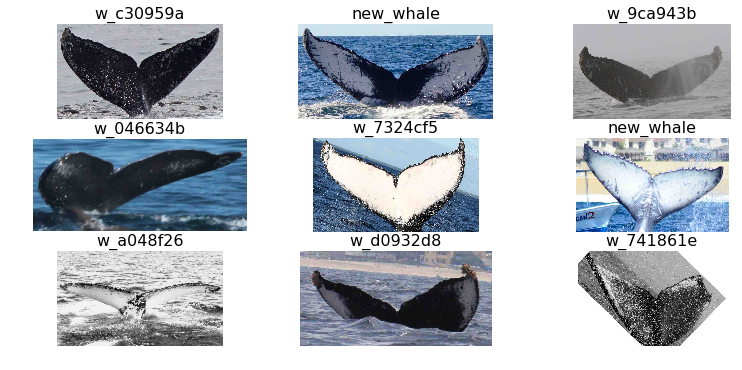

In [4]:
np.random.seed(100)

rand_rows = train_df.sample(frac=1.)[:9]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

We noticed there are a lot of very similar images and several even identical. That's why we decided to find such images.

In [5]:
all_images = np.concatenate((train_df['Image'].values, submission_df['Image'].values))

In [6]:
train_dir = f'{INITIAL_DIR}/train/'
test_dir = f'{INITIAL_DIR}/test/'

def expand_path(img):
    if isfile(join(train_dir, img)): return join(train_dir, img)
    if isfile(join(test_dir, img)): return join(test_dir, img)
    return img

In [7]:
p2size = {}

for image_name in tqdm(all_images):
    image = pil_image.open(expand_path(image_name))
    p2size[image_name] = image.size

100%|██████████| 25460/25460 [00:15<00:00, 1593.79it/s]


In [8]:
def match(h1,h2):
    for p1 in  h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 = pil_image.open(expand_path(p1))
            i2 = pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1 / sqrt((a1 ** 2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2 / sqrt((a2 ** 2).mean())
            a = ((a1 - a2) ** 2).mean()
            if a > 0.1: return False
    return True

In [9]:
# If the images are close enough, associate the two phash values
p2h_dict_path = './metadata/p2h.pickle'
p2h = {}

if isfile(p2h_dict_path):
    with open(p2h_dict_path, 'rb') as f:
        p2h = pickle.load(f)
else:
    print('Calculate phashes for every image')
    for image_name in tqdm_notebook(all_images):
        image = pil_image.open(expand_path(image_name))
        p2h[image_name] = phash(image)
    
    # Group images by phash
    h2ps = {}

    for image, image_phash in p2h.items():
        if image_phash not in h2ps: 
            h2ps[image_phash] = []
        if image not in h2ps[image_phash]:
            h2ps[image_phash].append(image)
            
    # Find all distinct phash values
    unique_phashes = list(h2ps.keys())
            
    print('Find similar images')
    # Associate hashes of similar images
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(unique_phashes)):
        for h2 in unique_phashes[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                h2h[max(s1, s2)] = min(s1, s2)

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p,h in p2h.items():
        h = str(h)
        
        if h in h2h: 
            h = h2h[h]
        p2h[p] = h

In [10]:
h2ps = {}

for picture, h in p2h.items():
    h = str(h)
    if h in h2ps:
        h2ps[h].append(picture)
    else:
        h2ps[h] = [picture]

There is an example of similar images. Here we can see that it differs by the brightness and perhaps color contrast but the tails are identical.

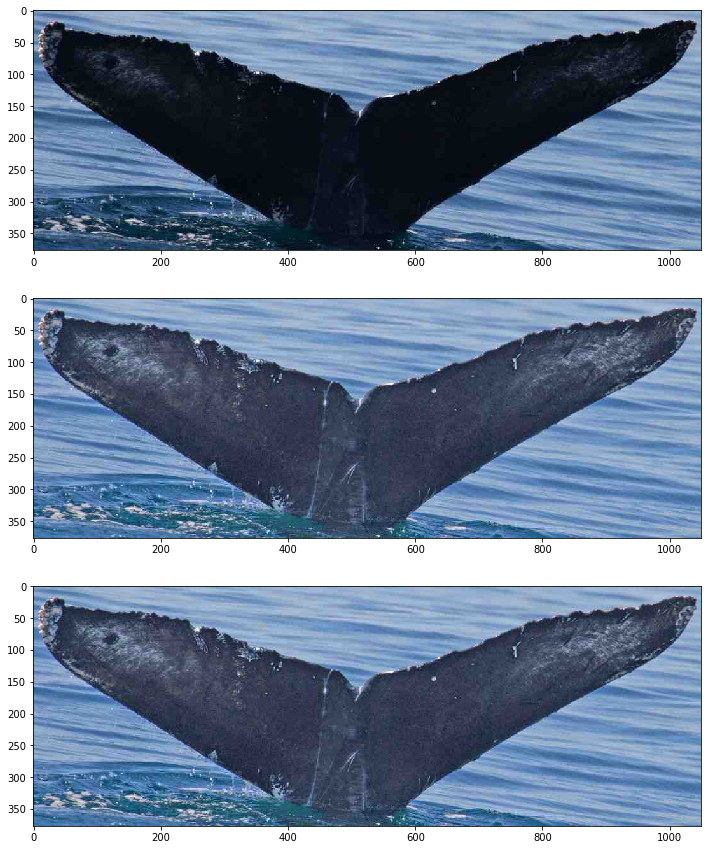

In [11]:
# Display duplicate images
# phash_duplicates = [images for images in hash_to_pictures.values() if len(images)>1]
dup = [i for i in h2ps.values() if len(i)==3][8:9]

phash_duplicates = dup
# figure size in inches optional
rcParams['figure.figsize'] = 15 ,15

# display images
fig, axes = plt.subplots(3, len(phash_duplicates))

for counter, (img1, img2, img3) in enumerate(phash_duplicates):
    image1 = pil_image.open(expand_path(img1))
    image2 = pil_image.open(expand_path(img2))
    image3 = pil_image.open(expand_path(img3))
    
    axes[0].imshow(image1);
    axes[1].imshow(image2);
    axes[2].imshow(image3);

In [12]:
len([images for images in h2ps.values() if len(images)>1])

4533

Along with it, there are only a few examples for each of 3,000+ whale ids. Let's take a look how many ids are in the dataset.

In [13]:
len(train_df['Id'].unique())

4251

Also, the data is very skewed in terms of the number of images per category. Let's draw the plot of the number of categories which have corresponded number of images.

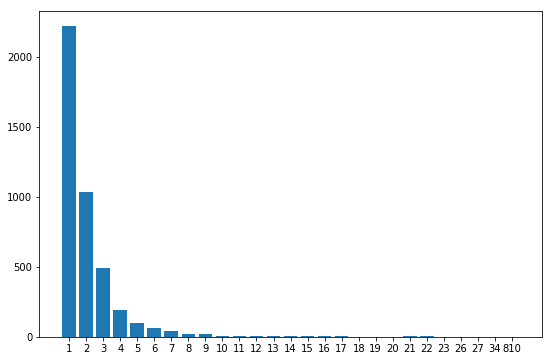

In [14]:
size_buckets = Counter(train_df['Id'].value_counts().values)
plt.figure(figsize=(9, 6))
plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1])

plt.show()

Let's look which categories have the biggest number of examples (810, 34, 27, etc.).

In [15]:
train_df['Id'].value_counts().head(5)

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
Name: Id, dtype: int64

As we can see, there is a $new\_whale$ category which corresponds to "undefined" whales i.e. whales which were not marked by scientists yet.

The total number images in the training set equals:

In [16]:
len(train_df['Id'])

9850

I guess the biggest issue is that $new\_whale$ category consists of the different whales. We can see it on the examples bellow.

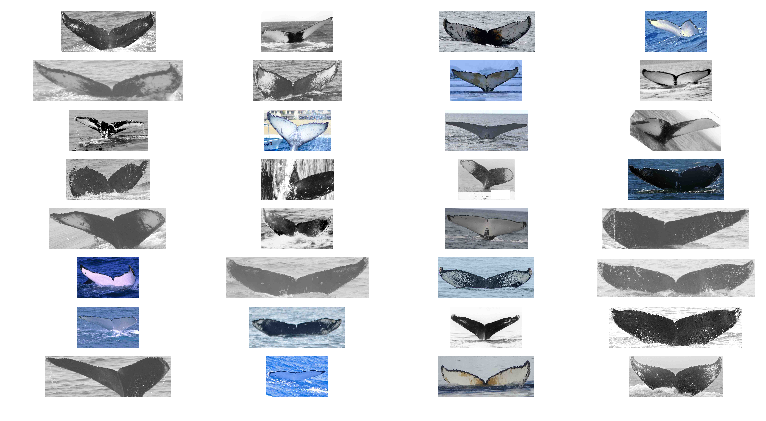

In [17]:
np.random.seed(100)
new_whale = train_df[train_df['Id'] == 'new_whale'][0:32]
plot_images_for_filenames(list(new_whale['Image']), None, rows=9)

Let's check the second biggest category

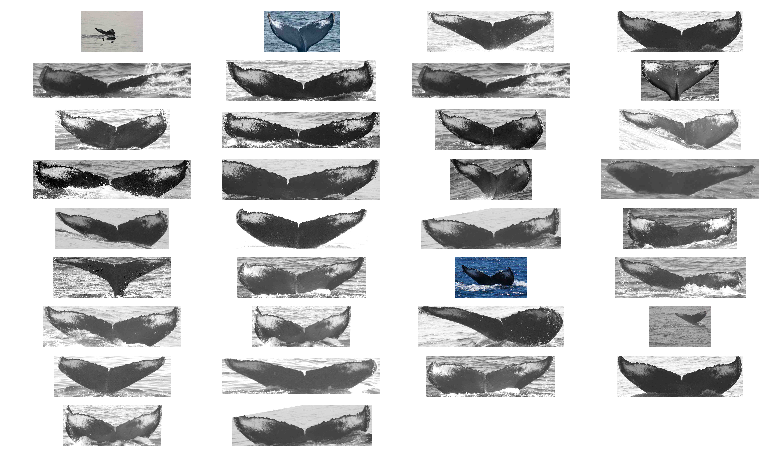

In [18]:
w_1287fbc = train_df[train_df['Id'] == 'w_1287fbc']
plot_images_for_filenames(list(w_1287fbc['Image']), None, rows=9)

There is an issue with providing validation because the vast majority of categories consist of one sample. In this case I believe we should perform data augmentation before creating a train/validation split. Let's take a look at a few examples of whales with only one example.

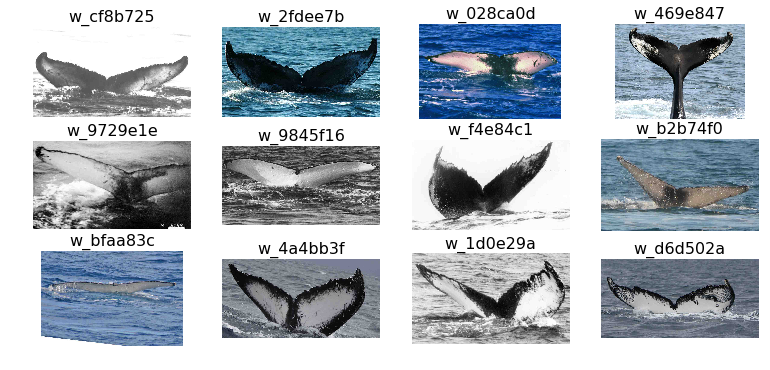

In [19]:
one_image_ids = train_df['Id'].value_counts().tail(12).keys()
one_image_filenames = []
labels = []
for i in one_image_ids:
    one_image_filenames.extend(list(train_df[train_df['Id'] == i]['Image']))
    labels.append(i)
    
plot_images_for_filenames(one_image_filenames, labels, rows=4)

The next step is to check the shapes of the images and its distribution. Let build a bar plot of image shapes frequencies.

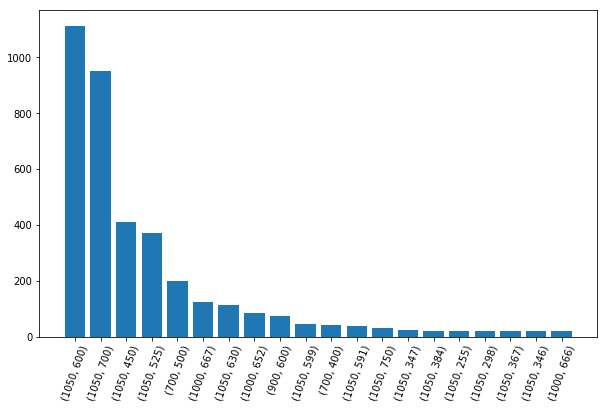

In [20]:
img_sizes = Counter([Image.open(f'{INITIAL_DIR}/train/{i}').size for i in train_df['Image']])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))
plt.figure(figsize=(10, 6))
plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.show()

The image shapes are not equal. So we should lead it to the same size. We decided to use $256\times 256$ image size.

As it was mentioned above, there are a lot of categories which have a few images. In this case, it is good practice to add some image augmentation. Let's see some examples.

In [21]:
import random

def random_greyscale(img, p):
    if random.random() < p:
        return np.dot(img[...,:3], [0.299, 0.587, 0.114])
    
    return img

def augmentation_pipeline(img_arr):
#     img_arr = random_rotation(img_arr, 18, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_zoom(img_arr, zoom_range=(0.9, 2.0), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_greyscale(img_arr, 0.4)


    return img_arr

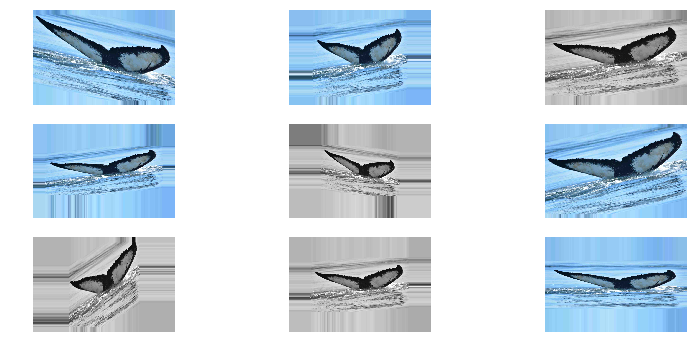

In [22]:
img = Image.open(f'{INITIAL_DIR}/train/0ae90da3.jpg')
img_arr = img_to_array(img)

np.random.seed(15)

imgs = [augmentation_pipeline(img_arr) * 255 for _ in range(9)]
plot_images(imgs, None)

One more interesting thing related to the dataset is that there are several images which are rotated to the orifinal images. There is an example.

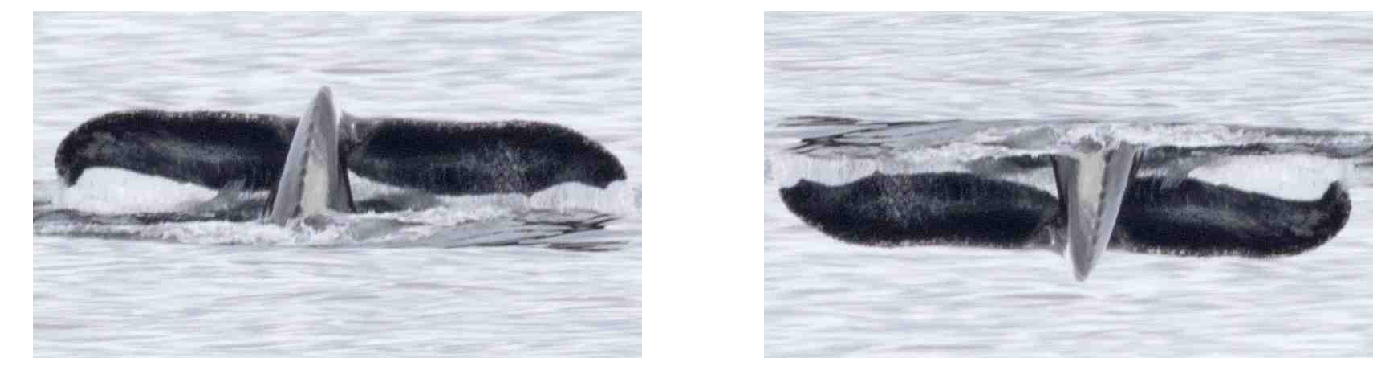

In [23]:
def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    if p in rotate: img = img.rotate(180)
    return img

rotate = {
    '2b792814.jpg',
    '2bc459eb.jpg',
    '3401bafe.jpg',
    '56fafc52.jpg',
    'a492ab72.jpg',
    'd1502267.jpg',
    'e53d2b96.jpg',
    'ed4f0cd5.jpg',
    'f2ec136c.jpg',
    'f966c073.jpg'
}

p    = list(rotate)[1]
imgs = [pil_image.open(expand_path(p)), read_raw_image(p)]
show_whale(imgs)

There are images with 2 whale's tails or displaying more than whale's tail. So we decided to exclude such images from the train set. There are all such images which were excluded.

In [24]:
with open(f'{INITIAL_DIR}/excluded.txt', 'rt') as f: exclude = f.read().split('\n')[:-1]   
len(exclude)

25

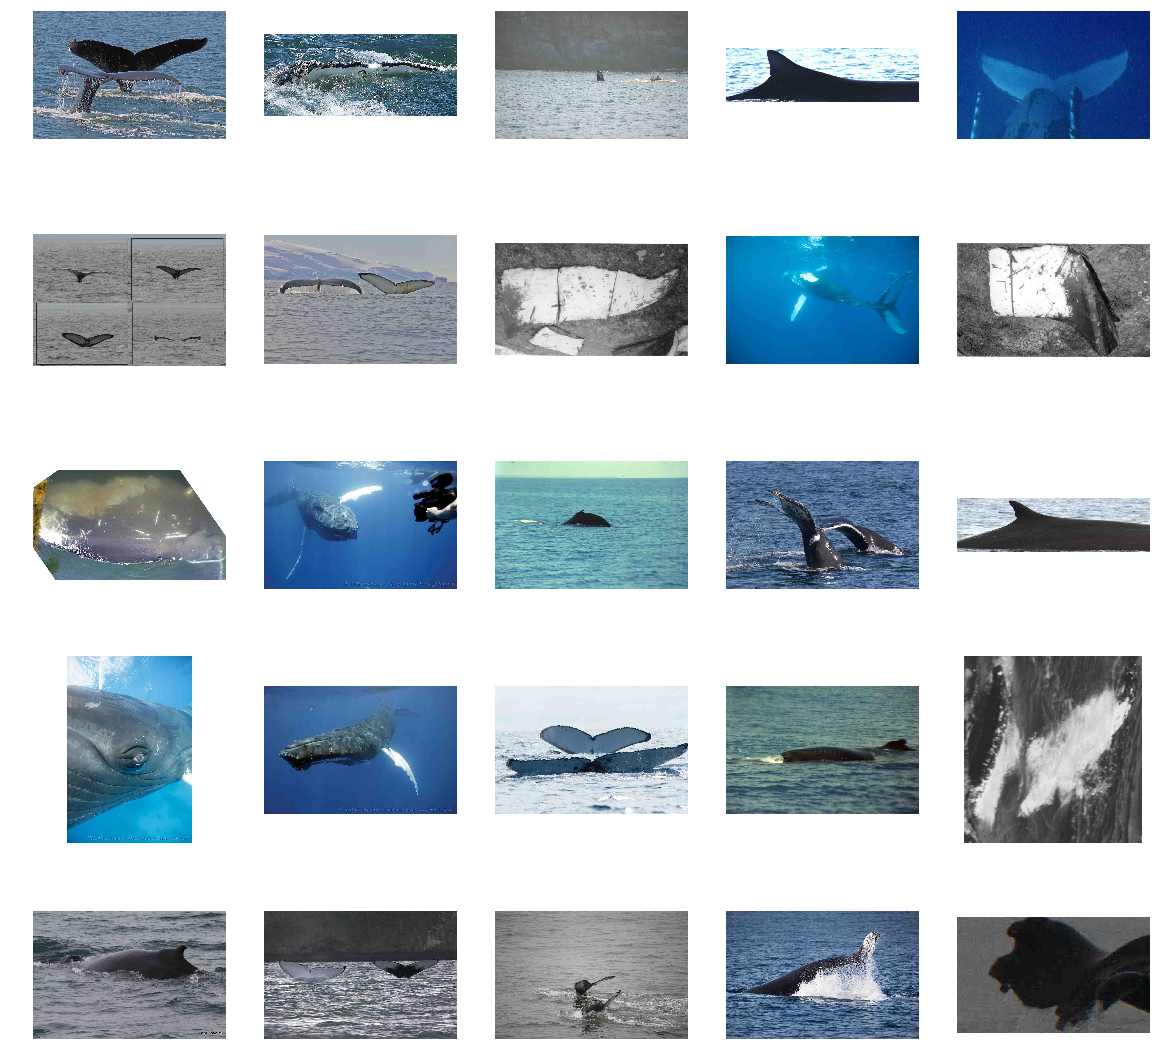

In [25]:
show_whale([read_raw_image(p) for p in exclude], per_row=5)

## PCA

In [26]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import random
import operator

In [27]:

X = []

w,h = 100, 60

for i,r in train_df.iterrows():
    filename = r[0]    
    img = cv2.imread(f'{INITIAL_DIR}/train/{filename}')
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
#     plt.imshow(img, cmap='gray')

    X.append(img.reshape((w*h)))
    
X = np.array(X)

print(X.shape)

(9850, 6000)


In [28]:
pca = PCA(n_components=16).fit(X)

print(pca.singular_values_)

[269997.81018214 166908.70532612 125936.71553701  89787.3946931
  84502.26673667  79252.38853342  71427.34990638  59644.18336407
  52059.03011371  48788.19363293  44042.02480223  42765.59480104
  41763.33606026  40678.95208445  39304.08315239  34996.11107992]


In [29]:
print(np.sum(pca.explained_variance_ratio_))

0.7332926437866887


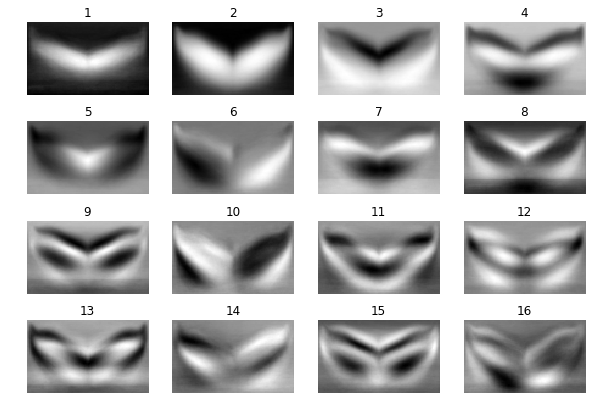

In [30]:
C = pca.components_

rows, columns = 4, 4
fig, axes = plt.subplots(rows, columns)

fig.set_size_inches(10, 7)
    
index = 0
for i in range(rows):
    for j in range(columns):        
        img = C[index].reshape((h,w))
        axes[i,j].set_title(str(index+1))
        axes[i,j].axis('off')
        axes[i,j].imshow( img, cmap='gray' )
        index += 1

plt.show()


# plt.imshow(C[1].reshape((h,w)), cmap='gray')

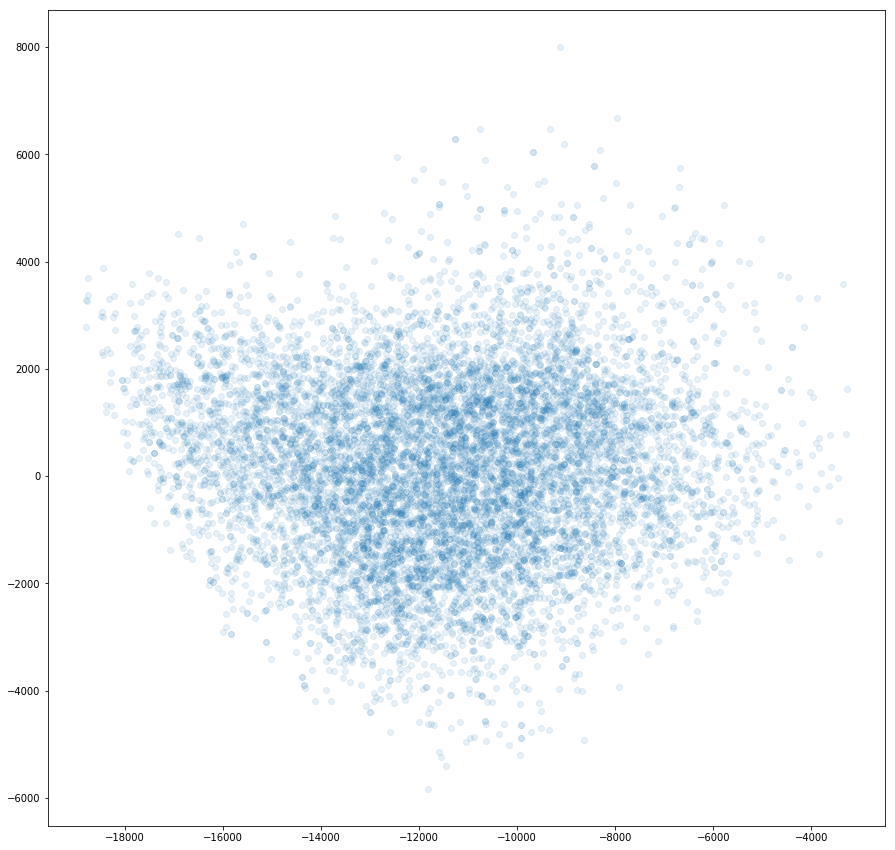

In [31]:
P = (X@C.T).T

plt.scatter(P[0], P[1], alpha=0.1)

In [33]:
tdf = train_df
class_size = dict()
for i,r in tdf.iterrows():
    if r['Id'] in class_size:
        class_size[r['Id']] += 1
    else:
        class_size[r['Id']] = 1

class_size =  sorted(class_size.items(), key=operator.itemgetter(1))[::-1]

class_size[:5]

[('new_whale', 810),
 ('w_1287fbc', 34),
 ('w_98baff9', 27),
 ('w_7554f44', 26),
 ('w_1eafe46', 23)]

In [34]:
tdf['p0'] = P[0]
tdf['p1'] = P[1]

labels = np.unique(tdf['Id'])
c_col = dict()

for (i,l) in enumerate(labels):
    c_col[l] = '#CCCCCC'
    
colors = ['#FF0000', '#00FF00', '#FFFF00', '#FF00FF', '#00FFFF']

for (i,cs) in enumerate(class_size[:5]):
    c_col[cs[0]] = colors[i]

tdf['color'] = ''
tdf['label'] = 'Other'

classes = []
class_colours = []

for i,r in tdf.iterrows():
    tdf.loc[i, 'color'] = c_col[r['Id']]
    
    if r['Id'] in c_col:
        tdf.loc[i, 'label'] = r['Id']
    
    if r['Image'] in exclude:
        tdf.loc[i, 'color'] = '#0000FF'
        tdf.loc[i, 'label'] = 'Excluded'
        
    if tdf.loc[i, 'color'] not in class_colours:
        class_colours.append(tdf.loc[i, 'color'])
        
        if tdf.loc[i, 'label'] not in classes:
            classes.append(tdf.loc[i, 'label'])

classes[0] = 'Other'

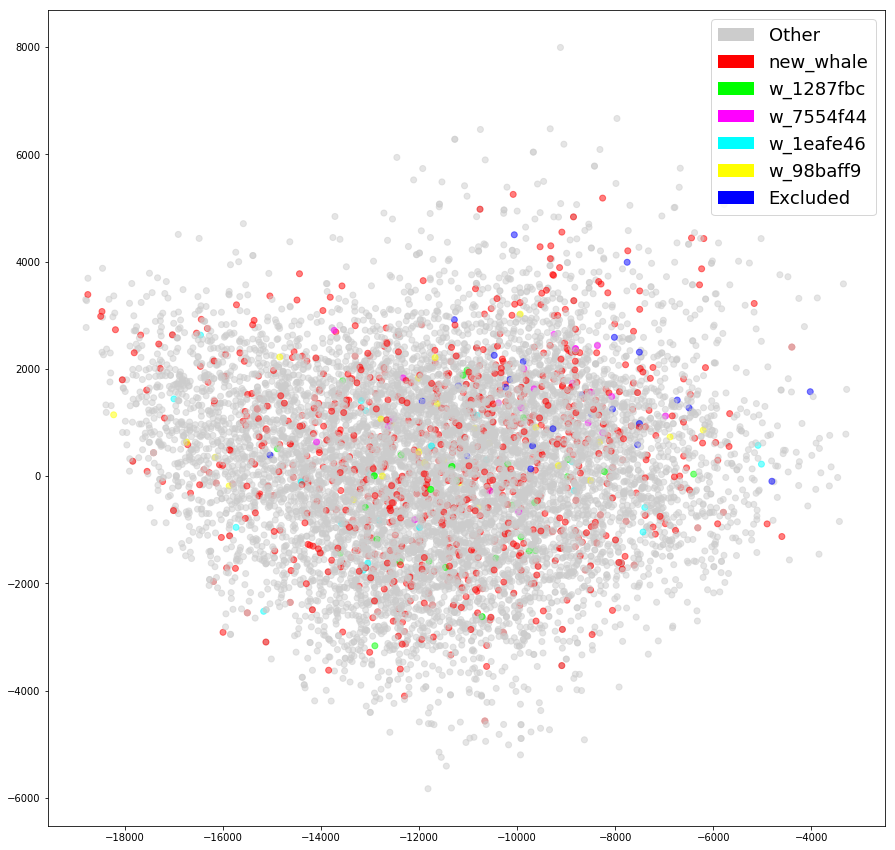

In [35]:
labels
# tdf.head()

classes[1], classes[2] = classes[2], classes[1]
class_colours[1], class_colours[2] = class_colours[2], class_colours[1]

recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

plt.scatter(tdf['p0'], tdf['p1'], c=tdf['color'], alpha=0.5, label=tdf['label'])
plt.legend(recs,classes,loc=1, fontsize=18)

## Modeling

(441, 1071, 3)


True

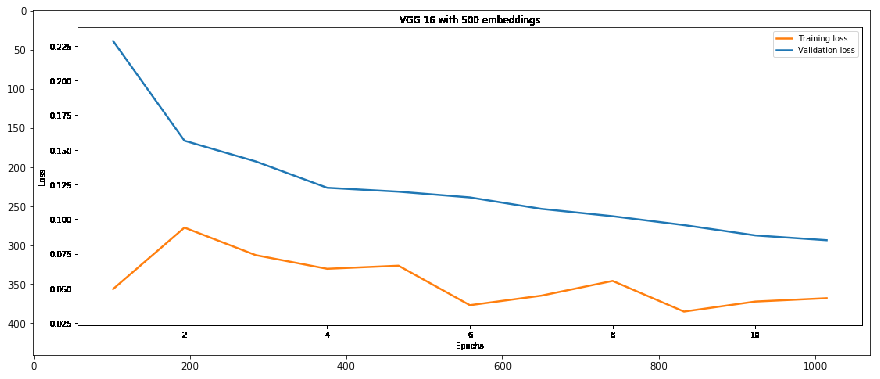

In [98]:
img = cv2.imread('vgg16.png')

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

print(img.shape)

# plt.imshow(img[45:58, 948:975])  # orange

# plt.show()

# plt.imshow(img[30:43, 948:975])  # blue

orange = img[45:58, 948:975].copy()
blue = img[30:43, 948:975].copy()

img[45:58, 948:975], img[30:43, 948:975] = blue, orange

plt.imshow(img)

img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

cv2.imwrite('vgg16_res.png',img)

In [101]:
edf = pd.read_csv('embeddings.csv')

In [119]:
print(edf.iloc[[0]]['Image'][0])

train_df.loc[train_df['Image'] == 'tretrt']

00022e1a.jpg


0

In [255]:
E = []
Imgs = []
Ids = []

for i,r in train_df.iterrows():
    emb = edf.loc[edf['Image'] == r[0]]
    if len(emb) == 1:
        emb = emb.values[0]
        Imgs.append(emb[1])
        Ids.append(r[1])
        E.append([float(x) for x in emb[2].split(' ')])
#     break
    
    
E = np.array(E)

print(E.shape)

(8016, 500)


In [197]:
e_pca = PCA(n_components=2).fit(E)

In [198]:
print(e_pca.singular_values_)

print(np.sum(e_pca.explained_variance_ratio_))

[345.60468938 320.99122553]
0.1510248028247281


In [206]:
EC = e_pca.components_

In [209]:
EP = (E@EC.T).T

In [237]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(filename):
#     path = (f'{INITIAL_DIR}/train/{filename}')

    img = cv2.imread(f'{INITIAL_DIR}/train/{filename}')
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(img, (30, 30), interpolation = cv2.INTER_AREA)

    return OffsetImage(img)

# getImage('00022e1a.jpg')

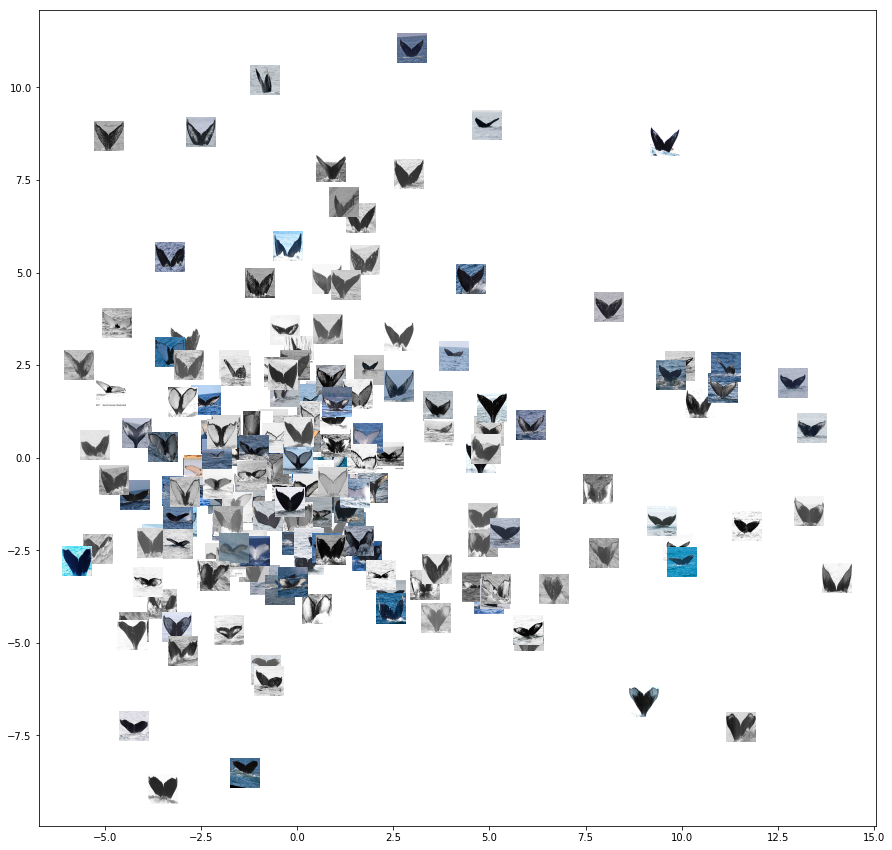

In [238]:
np.random.seed(100)
num = 200
indexes = np.random.choice([x for x in range(len(EP[0]))], num, replace=False)


fig, ax = plt.subplots()

ax.scatter(EP[0][indexes], EP[1][indexes], alpha=0.5)

for i in indexes:
    im_path = Imgs[i]
    x0, y0 = EP[0][i], EP[1][i]
    ab = AnnotationBbox(getImage(im_path), (x0, y0), frameon=False)
    ax.add_artist(ab)


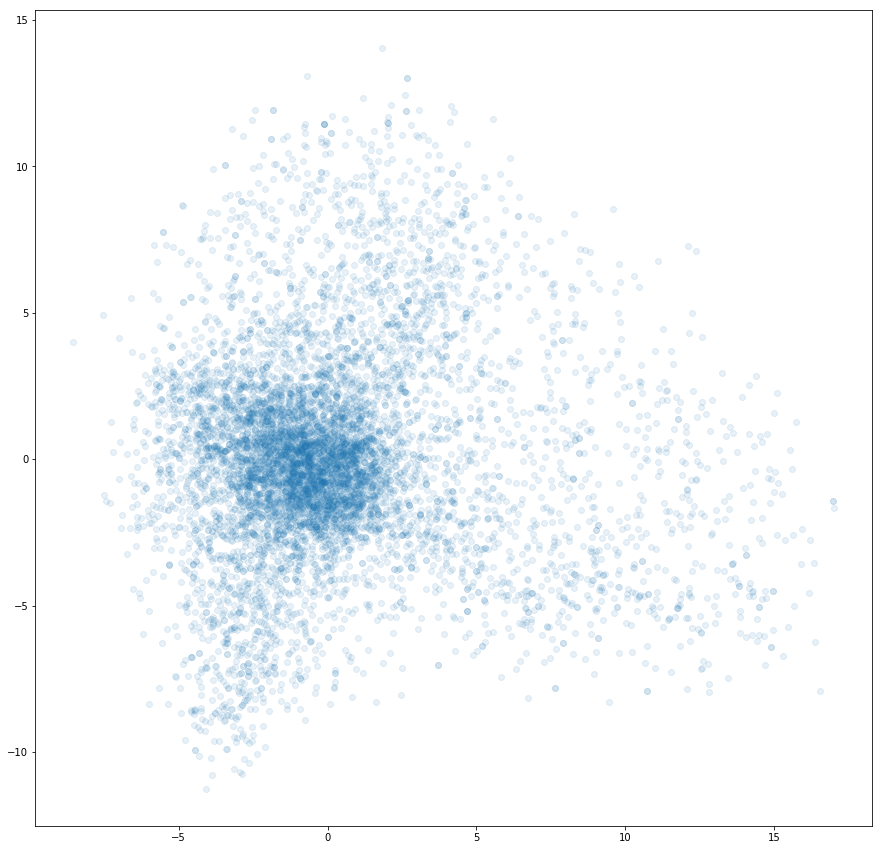

In [242]:
plt.scatter(EP[0], EP[1], alpha=0.1)

In [256]:
e_tdf = pd.DataFrame(EP.T, columns=['p0', 'p1'])
e_tdf['Image'] = Imgs
e_tdf['Id'] = Ids



e_tdf.head()

p0        p1         Image         Id
0 -4.559188  3.472933  00022e1a.jpg  w_e15442c
1 -0.611796 -1.247639  001296d5.jpg  w_19e5482
2  0.843681  1.644686  0014cfdf.jpg  w_f22f3e3
3 -1.106596 -1.605888  0026a8ab.jpg  w_eaad6a8
4 -3.876941 -5.740387  0042dcc4.jpg  w_6dc7db6

In [262]:
class_size = dict()
for i,r in e_tdf.iterrows():
    if r['Id'] in class_size:
        class_size[r['Id']] += 1
    else:
        class_size[r['Id']] = 1

class_size =  sorted(class_size.items(), key=operator.itemgetter(1))[::-1]

class_size[:10]

[('w_1287fbc', 33),
 ('w_98baff9', 26),
 ('w_7554f44', 24),
 ('w_1eafe46', 22),
 ('w_ab4cae2', 21),
 ('w_693c9ee', 21),
 ('w_fd1cb9d', 21),
 ('w_43be268', 20),
 ('w_987a36f', 20),
 ('w_73d5489', 20),
 ('w_f19faeb', 19),
 ('w_9b401eb', 18),
 ('w_95874a5', 18),
 ('w_b7d5069', 17),
 ('w_c0d494d', 17),
 ('w_0e737d0', 16),
 ('w_18eee6e', 16),
 ('w_eb0a6ed', 16),
 ('w_dbda0d6', 16),
 ('w_17ee910', 15)]

In [283]:


e_tdf['p0'] = EP[0]
e_tdf['p1'] = EP[1]

labels = np.unique(e_tdf['Id'])
c_col = dict()

for (i,l) in enumerate(labels):
    c_col[l] = '#eeeeee'
    
colors = [
    '#FF0000', '#00FF00', '#FFFF00', '#FF00FF', '#00FFFF',
    '#c43339', '#418903', '#893d75', '#4736cd', '#b46e49'
]

for (i,cs) in enumerate(class_size[:10]):
    c_col[cs[0]] = colors[i]

e_tdf['color'] = ''
e_tdf['label'] = 'Other'

classes = []
class_colours = []

for i,r in e_tdf.iterrows():
    e_tdf.loc[i, 'color'] = c_col[r['Id']]
    
    if r['Id'] in c_col:
        e_tdf.loc[i, 'label'] = r['Id']
    
    if r['Image'] in exclude:
        e_tdf.loc[i, 'color'] = '#0000FF'
        e_tdf.loc[i, 'label'] = 'Excluded'
        
    if e_tdf.loc[i, 'color'] not in class_colours:
        class_colours.append(e_tdf.loc[i, 'color'])
        
        if tdf.loc[i, 'label'] not in classes:
            classes.append(e_tdf.loc[i, 'label'])

classes[0] = 'Other'

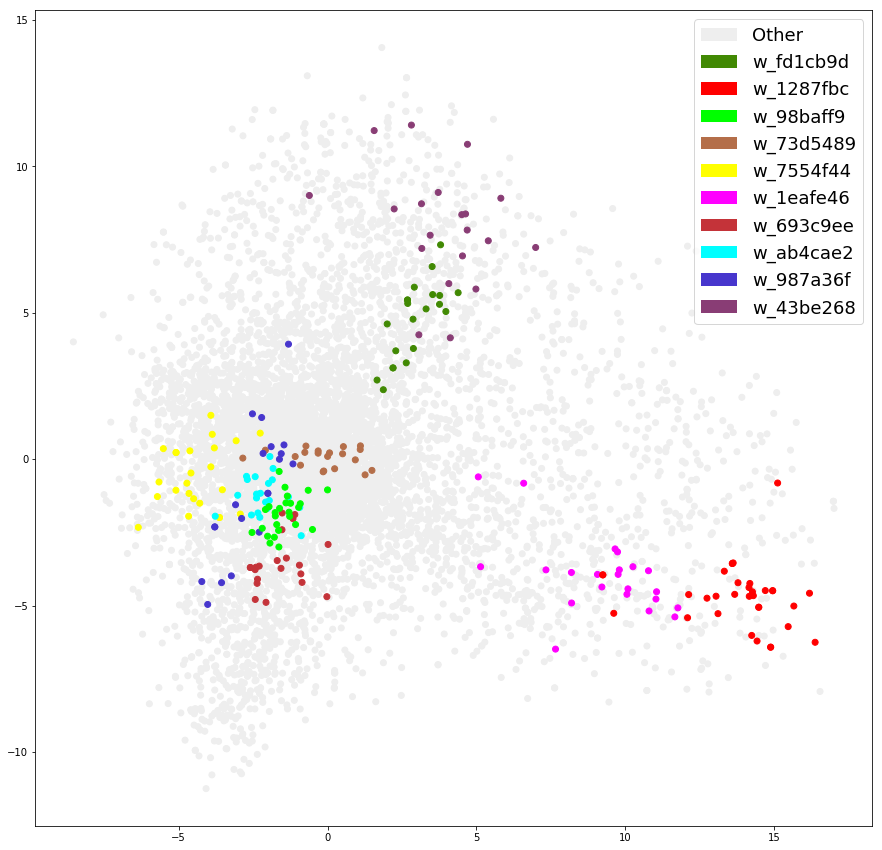

In [285]:
# classes[1], classes[2] = classes[2], classes[1]
# class_colours[1], class_colours[2] = class_colours[2], class_colours[1]

p_df = e_tdf
p_df = p_df.sort_values(by='color', ascending=False)

# print(p_df.head())

recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

plt.scatter(p_df['p0'], p_df['p1'], c=p_df['color'], alpha=1, label=p_df['label'])
plt.legend(recs,classes,loc=1, fontsize=18)